In [70]:
import os
import sys
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from datetime import datetime
from pathlib import Path
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyArrowPatch

import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy.util import add_cyclic_point
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

from scipy.stats import pearsonr

import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
# set fonts configuration - Arial
matplotlib.rcParams['font.family'] = "Open Sans"
matplotlib.rcParams['font.sans-serif'] = "Arial"

In [5]:
def BL_mcs_2dmap(fid_envs_track):
    """
    input: processed envs_track file containing MCS feature mask and 2D/3D variables on ERA-5 coordinates
    return BL componets within the tracked MCS feature
    """
    
    data = xr.open_dataset(fid_envs_track)
    BL_TOT = data.Buoy_TOT
    BL_CAPE = data.Buoy_CAPE
    BL_SUBSAT = data.Buoy_SUBSAT
    
    # maskout grids not covered by MCS 
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    BL_TOT_masked = BL_TOT.where(mcs_mask > 0)
    BL_CAPE_masked = BL_CAPE.where(mcs_mask > 0)
    BL_SUBSAT_masked = BL_SUBSAT.where(mcs_mask > 0)
    
    BL_TOT_env = BL_TOT.where(mcs_mask == 0)
    BL_CAPE_env = BL_CAPE.where(mcs_mask == 0)
    BL_SUBSAT_env = BL_SUBSAT.where(mcs_mask == 0)
    
    return BL_TOT_masked, BL_CAPE_masked, BL_SUBSAT_masked, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env

In [6]:
def precip_mcs_2dmap(fid_envs_track):
    """
    input: processed envs_track file containing MCS feature mask and 2D/3D variables on ERA-5 coordinates
    return BL componets within the tracked MCS feature
    """
    
    data = xr.open_dataset(fid_envs_track)
    prec_era5 = data.mtpr
    prec_gpm = data.precipitationCal
    
    # maskout grids not covered by MCS 
    mcs_mask = data.cloudtracknumber_nomergesplit # binary mask
    prec_era5_masked = prec_era5.where(mcs_mask > 0)
    prec_gpm_masked = prec_gpm.where(mcs_mask > 0)
    
    return prec_era5_masked, prec_gpm_masked

In [171]:
def cape_subsat_hist(files, multi_year=False):

    # bins for BL_CAPE and BL_SUBSAT
    bins_cape = np.linspace(-2,10,25)
    bins_subsat = np.linspace(-2,10,25)
    bins_samples = np.zeros((2, 5, len(bins_cape)-1, len(bins_subsat)-1)) # histograms for 5 MCS phases
    
    n = 0
    track_list = []
    for file in files: # total files read (single year or multiple years)
        
        if multi_year == True:
            n += 1 # total track numbers merged
            
        track_list.append(int(file.name[-11:-6])) # save track number 
        
        (BL_TOT, BL_CAPE, BL_SUBSAT, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env) = BL_mcs_2dmap(file)

        for p, phase in enumerate(["Init", "Grow", "Mature", "Decay", "End"]):

            thetae_ref = 340
            wb = 0.4
            wl = 0.6

            # ===== for inside mcs ======
            BL_CAPE_phase = BL_CAPE.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
            BL_CAPE_phase = BL_CAPE_phase/9.81*thetae_ref*3/wb
            BL_SUBSAT_phase = BL_SUBSAT.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
            BL_SUBSAT_phase = BL_SUBSAT_phase/9.81*thetae_ref*3/wl

            # get 1-D CAPE and SUBSAT values associated with MCS
            cape_1d = np.unique(BL_CAPE_phase)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT_phase)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[0,p,i,j] += len(idx_com)

            # ===== for outside mcs (environment) ======
            BL_CAPE_phase_env = BL_CAPE_env.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
            BL_CAPE_phase_env = BL_CAPE_phase_env/9.81*thetae_ref*3
            BL_SUBSAT_phase_env = BL_SUBSAT_env.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
            BL_SUBSAT_phase_env = BL_SUBSAT_phase_env/9.81*thetae_ref*3

            # get 1-D CAPE and SUBSAT values associated with the environment
            cape_1d = np.unique(BL_CAPE_phase_env)[:-1] # the last one is NaN
            subsat_1d = np.unique(BL_SUBSAT_phase_env)[:-1] # the last one is NaN 

            for i in range(len(bins_cape)-1):
                idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
                for j in range(len(bins_subsat)-1):
                    idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                    idx_com = np.intersect1d(idx,idy)
                    bins_samples[1,p,i,j] += len(idx_com)
    
    if multi_year == False:
    
        ds_bins = xr.Dataset(data_vars = dict(samples = (['area','phase','bins_cape','bins_subsat'], bins_samples)),
                 coords = dict(tracks = track_list,
                               area = (['area'],['mcs','env']),
                               phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay', 'End']),
                               bins_cape = (['bins_cape'], bins_cape[:-1]),
                               bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                 attrs = dict(description = 'cape-subsat histogram. 2014'))
    else:
        ds_bins = xr.Dataset(data_vars = dict(samples = (['area','phase','bins_cape','bins_subsat'], bins_samples)),
                 coords = dict(tracks = np.arange(n),
                               area = (['area'],['mcs','env']),
                               phase = (['phase'], ['Initial', 'Grow', 'Mature', 'Decay', 'End']),
                               bins_cape = (['bins_cape'], bins_cape[:-1]),
                               bins_subsat = (['bins_subsat'], bins_subsat[:-1])),
                 attrs = dict(description = 'cape-subsat histogram. 2014'))
    
    return ds_bins

In [8]:
def plot_hist_cape_subsat(data_bins, sup_title):

    # read written output
    #data_bins = xr.open_dataset(dir_out /  'mcs_cape_subsat_histogram_tropics.nc')
    bins_cape = data_bins.bins_cape
    bins_subsat = data_bins.bins_subsat
    bins_sample = data_bins.sel(area='mcs').samples.values

    # plot histogram : fraction of occurrences at different MCS phases

    fig, ((ax1,ax2,ax3,ax4,ax5),(ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

    for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):

        tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
        tmp[tmp == 0] = np.nan

        cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                        vmin=0, vmax=0.02, cmap=mixedmap)

        # contour: fraction of occurrence
        ax.contour(bins_subsat, bins_cape, tmp,
                  levels=[0.005, 0.0075, 0.01, 0.0125, 0.015], colors=['k'], linewidths=1)

        if n == 4:
            caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
            cbar = plt.colorbar(cp, cax=caxes)
            cbar.set_label('Fraction')
        ax.set_title(mcs_phase)
        ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
        ax.set_ylim([-2, 6])
        ax.set_xlim([-2, 9])

        # buoyancy reference lines
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+4, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-4, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 
        ax.set_xticks([0, 2, 4, 6, 8])
        ax.grid(linestyle=':', linewidth=0.5)

        # plot mean states of BL_CAPE and BL_SUBSAT
        mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
        mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

    for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):

        tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
        tmp[tmp == 0] = np.nan

        cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                        vmin=-0.005, vmax=0.005, cmap='RdBu')
        if n == 4:
            caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
            cbar = plt.colorbar(cp, cax=caxes)
            cbar.set_label('$\Delta$Fraction (rel. to Mat.)')
        ax.set_title(mcs_phase)
        ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
        ax.set_ylabel('BL_CAPE (K)',fontsize=12)
        ax.set_ylim([-2, 6])
        ax.set_xlim([-2, 9])
        ax.set_xticks([0, 2, 4, 6, 8])
        ax.grid(linestyle=':', linewidth=0.5)

        # buoyancy reference lines
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+4, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
        ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-4, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

        # plot mean states of BL_CAPE and BL_SUBSAT
        mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
        mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')

    plt.tight_layout()
    plt.suptitle(sup_title, fontsize=16
                 , fontweight='bold', y=1.1)    
    
    return fig

In [170]:
def data_tracks_precip_features(files):
    """
    return tracks by BL_TOT bins (unit: K)
    """
    
    track_list = []
    precip_features_list = []    
    corr_coeff_temp = []
        
    for file in files:
        
        track_list.append(int(file.name[-11:-6])) # save track number 
        
        tmp = xr.open_dataset(file)
        # calculate precip amplitude within mcs
        prec_mcs = tmp.precipitationCal.where(tmp.cloudtracknumber_nomergesplit > 0)
        mtpr_mcs = tmp.mtpr.where(tmp.cloudtracknumber_nomergesplit > 0)
        prec_amp_mcs = prec_mcs.mean(('x','y')).rename('precipitationCal_mcs')
        mtpr_amp_mcs = mtpr_mcs.mean(('x','y')).rename('mtpr_mcs')
        
        prec_mcs = tmp.precipitationCal.where(tmp.cloudtracknumber_nomergesplit > 0, 0)
        mtpr_mcs = tmp.mtpr.where(tmp.cloudtracknumber_nomergesplit > 0, 0)
        # estimate spatial correlation 
        corr_coeff = []
        for phase in tmp.mcs_phase:
            prec_era5 = prec_mcs.sel(mcs_phase=phase)
            prec_gpm = mtpr_mcs.sel(mcs_phase=phase)
            stats = pearsonr(prec_era5.values.ravel(), prec_gpm.values.ravel())
            corr_coeff.append(stats[0]) # save correlation coefficient 
        corr_coeff_space = xr.Dataset(data_vars=dict(corr_coeff_space=(['mcs_phase'],np.asarray(corr_coeff))),
                                 coords=dict(mcs_phase=(['mcs_phase'], tmp.mcs_phase.values)))
        
        # estimate temporal correlation 
        corr_coeff_temp.append(pearsonr(prec_amp_mcs.values.ravel(), mtpr_amp_mcs.values.ravel())[0])
        
        precip_features_list.append(xr.merge([prec_amp_mcs ,mtpr_amp_mcs,
                                              corr_coeff_space]))
    
    corr_coeff_temp_xr = xr.Dataset(data_vars=dict(corr_coeff_temp=(['tracks'],np.asarray(corr_coeff_temp))),
                                 coords=dict(tracks=(['tracks'], track_list)))
    precip_features_xr = xr.concat(precip_features_list, pd.Index(track_list, name='tracks'))

    # merge two datasets
    precip_features_xr = xr.merge([precip_features_xr, corr_coeff_temp_xr])
    
    return precip_features_xr

In [180]:
# def get_files_HCC(year):
#     """
#     get files with high rainfall correlation
#     """
#     # directory of the mcs_3dvars files
#     dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))
#     files = sorted(list(dir_envs_track.glob('*.LD.nc')))

#     # load precip data phase
#     data_precip_features = data_tracks_precip_features(files) # (track, phase)
#     corr_temp = data_precip_features.corr_coeff_temp
#     corr_coeff_space = data_precip_features.corr_coeff_space.mean('mcs_phase')
    
#     # filtering out tracks with low coherency in precip evolution
#     cond_1 = corr_temp > 0.7
#     cond_2 = corr_coeff_space > 0
    
#     track_HCC = data_precip_features.isel(tracks=np.where(cond_1 & cond_2)[0]).tracks # filtered mcs tracknumber
    
#     files_HCC = []
#     for track in track_HCC.values:
#         files_HCC.extend(list(dir_envs_track.glob('mcs_era5_3D_envs_{}.{}.LD.nc'.format(year,str(track).zfill(5)))))
        
#     return files_HCC

In [184]:
def get_files_HCC(year, corr_temp_cri, corr_space_cri):
    
    featstats_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs/tracks_area_mean/')
    data = xr.open_dataset(featstats_dir / 'featstats_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    
    corr_coeff_temp = data.corr_coeff_temp
    corr_coeff_space = data.corr_coeff_space.mean('mcs_phase')
    
    cond_1 = corr_coeff_temp > corr_temp_cri
    cond_2 = corr_coeff_space > corr_space_cri
    track_sel = data.isel(tracks=np.where(cond_1 & cond_2)[0]).tracks
    
    dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))
    files_HCC = []
    for track in track_sel.values:
        files_HCC.extend(list(dir_envs_track.glob('mcs_era5_3D_envs_{}.{}.LD.nc'.format(year
                                                                    , str(track).zfill(5)))))
    return files_HCC

#### Main codes
1. select mcs tracks with high correlation of GPM and EAR-5 precip in time (phase)
2. calculate and plot cape-subsat histograms of MCSs (all, short-lived MCSs, long-lived MCSs)

In [24]:
%%time
# directory of the mcs_3dvars files
year_list = [2015, 2016, 2017, 2018, 2019]
files_HCC = []
for year in year_list:
    dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))
    #files_HCC.extend(get_files_HCC(year))
    files_HCC.extend(list(dir_envs_track.glob('*.nc')))

data_bins = cape_subsat_hist(files_HCC, multi_year=True)

CPU times: user 47min 44s, sys: 49.4 s, total: 48min 34s
Wall time: 1h 1min 34s


In [25]:
## figure out
fig_dir = Path('/neelin2020/mcs_flextrkr/mcs_stats/figs')

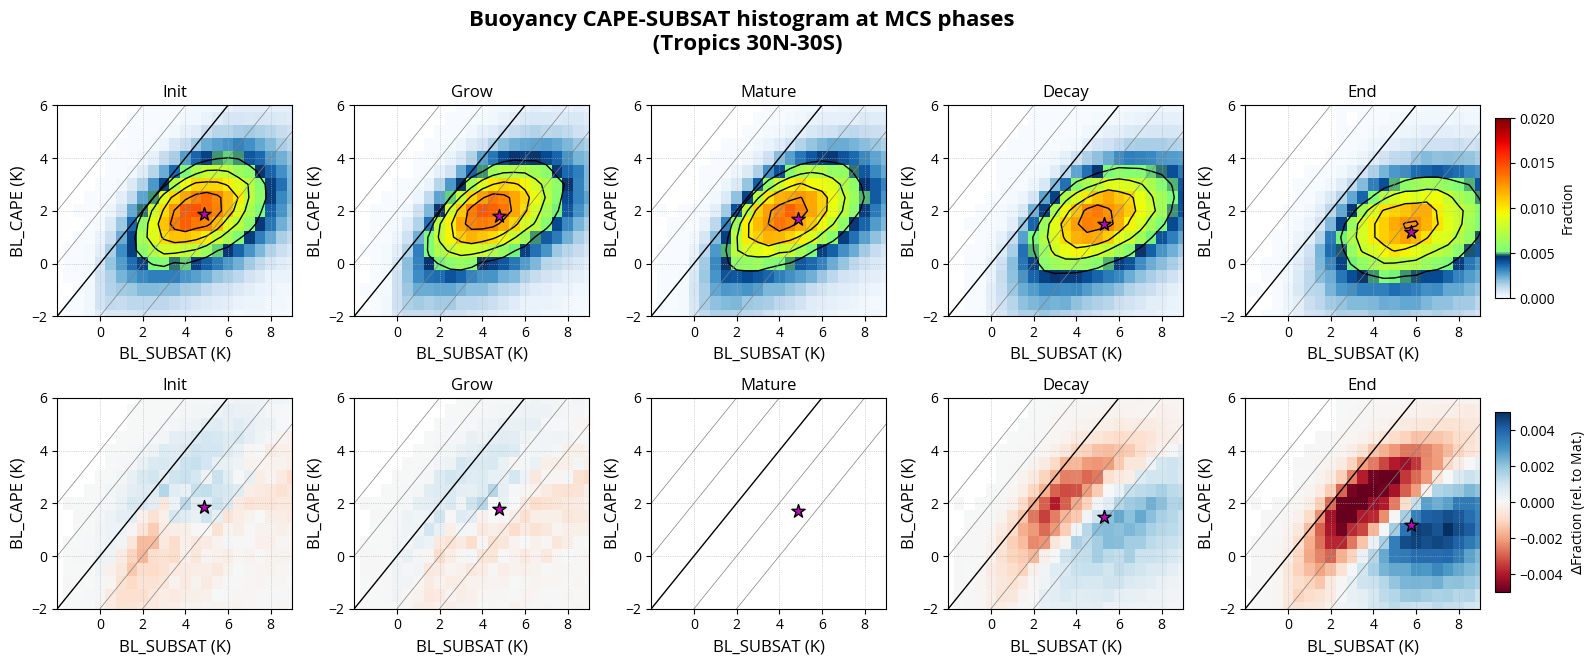

In [26]:
fig = plot_hist_cape_subsat(data_bins, sup_title = 'Buoyancy CAPE-SUBSAT histogram at MCS phases \n (Tropics 30N-30S)')
fig.savefig(fig_dir / 'MCS_cape_subsat_histogram_tropics30NS.pdf',
           bbox_inches='tight'
           )

In [27]:
%%time
### MCS lifetimes: short-lived
year_list = [2015, 2016, 2017, 2018, 2019]

files = []
for year in year_list:
    
    dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))
    dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    # duration : < 12H
    idx = np.where(np.logical_and(data_track.mcs_duration > 5, data_track.mcs_duration <= 12))[0]
    mcs_id = data_track.isel(tracks=idx).tracks.values

    for track_num in mcs_id:
        files.extend(list(dir_envs_track.glob('mcs_era5_3D_envs_{}.{}.nc'.format(year,str(track_num).zfill(5)))))
    
data_bins_SL = cape_subsat_hist(files, multi_year=True)

CPU times: user 15min 27s, sys: 9.55 s, total: 15min 37s
Wall time: 17min 1s


In [28]:
%%time
### MCS lifetimes: long-lived
year_list = [2015, 2016, 2017, 2018, 2019]

files = []
for year in year_list:
    
    dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))
    dir_mcs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/mcs_tracks_non2mcs')
    data_track = xr.open_dataset(dir_mcs_track / 'mcs_tracks_non2mcs_{}.tropics30NS.nc'.format(year))
    # duration : > 24H
    idx = np.where(np.logical_and(data_track.mcs_duration > 24, data_track.mcs_duration <= 80))[0]
    mcs_id = data_track.isel(tracks=idx).tracks.values

    for track_num in mcs_id:
        files.extend(list(dir_envs_track.glob('mcs_era5_3D_envs_{}.{}.nc'.format(year,str(track_num).zfill(5)))))
    
data_bins_LL = cape_subsat_hist(files, multi_year=True)

CPU times: user 2min 58s, sys: 1.82 s, total: 3min
Wall time: 3min 21s


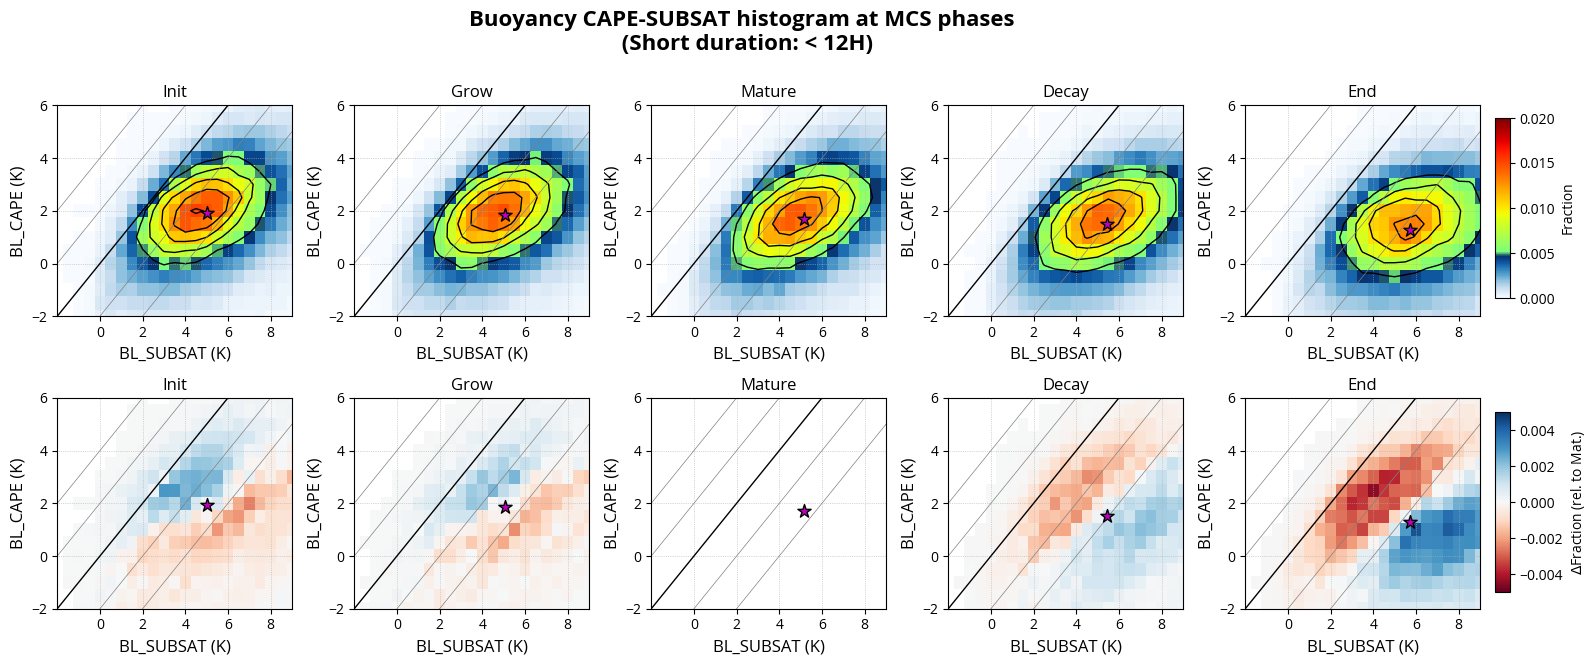

In [29]:
fig = plot_hist_cape_subsat(data_bins_SL, sup_title = 'Buoyancy CAPE-SUBSAT histogram at MCS phases \n (Short duration: < 12H)')
fig.savefig(fig_dir / 'MCS_cape_subsat_histogram_tropics30NS_shortlived.pdf',
           bbox_inches='tight')

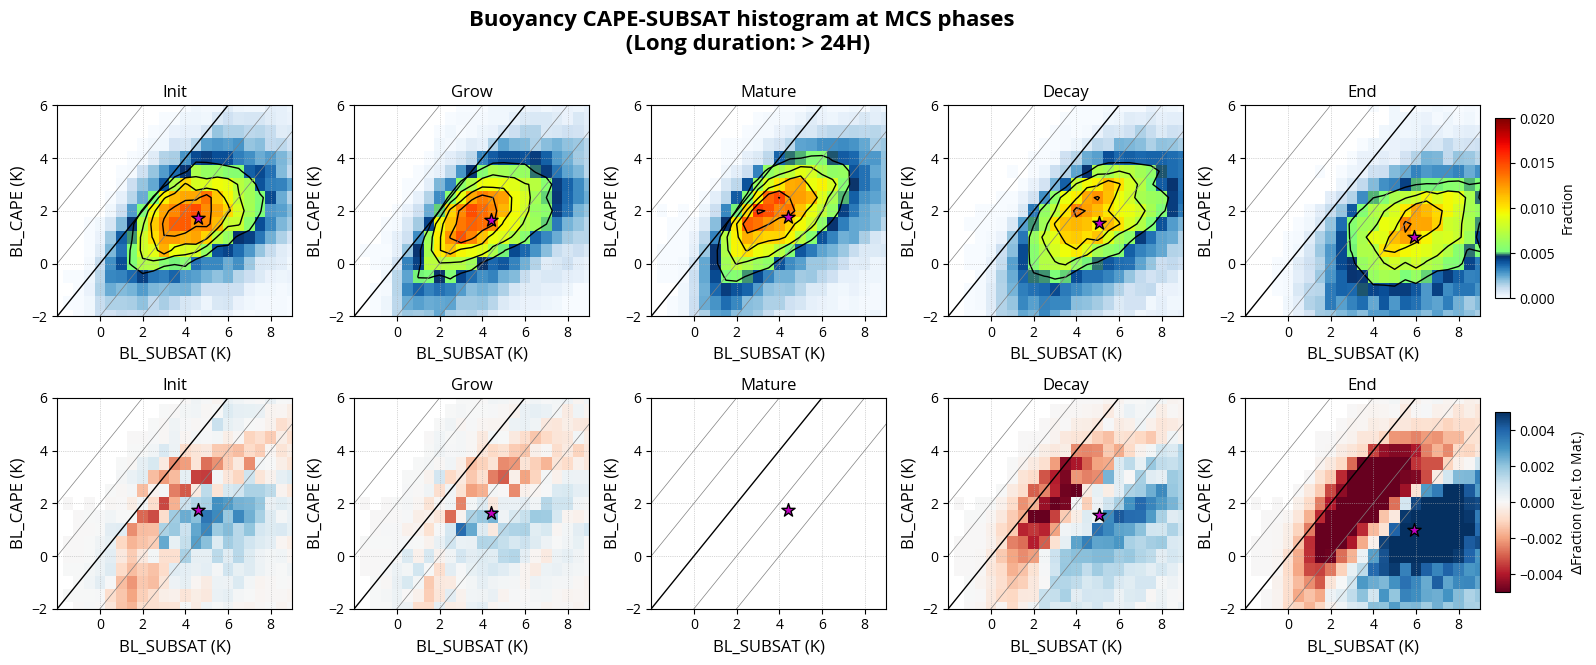

In [30]:
fig = plot_hist_cape_subsat(data_bins_LL, sup_title = 'Buoyancy CAPE-SUBSAT histogram at MCS phases \n (Long duration: > 24H)')
fig.savefig(fig_dir / 'MCS_cape_subsat_histogram_tropics30NS_longlived.pdf',
           bbox_inches='tight')

Text(4.7, 0.72, '-4K')

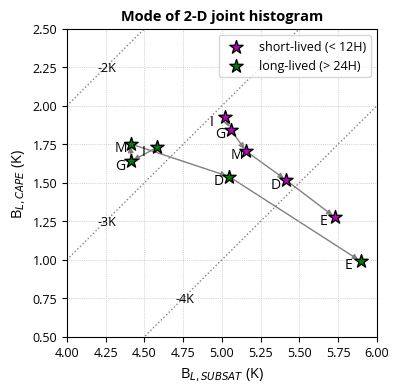

In [102]:
# position of mode
# read written output
fig, ax = plt.subplots(1,1,figsize=(4,4))

bins_cape = data_bins_SL.bins_cape
bins_subsat = data_bins_SL.bins_subsat
bins_sample = data_bins_SL.sel(area='mcs').samples.values

position_arrow = []
for n, (mcs_phase, phase_string) in enumerate(zip(['Init','Grow','Mature','Decay','End']
                                              ,['I','G','M','D','E'])):

    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
    tmp[tmp == 0] = np.nan
    
    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    if n == 0:
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k'
                   , label='short-lived (< 12H)')
    else:
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='m', zorder=2, edgecolor='k')
    position_arrow.append((mean_subsat, mean_cape))

    # MCS phase string
    ax.text(mean_subsat-0.1, mean_cape-0.05, phase_string)
    
# plotting arrow between markers
for n in range(len(position_arrow)-1):
    arrow = FancyArrowPatch(posA=position_arrow[n], posB=position_arrow[n+1], 
                                    arrowstyle='-|>', mutation_scale=8, color='grey')
    ax.add_patch(arrow)    

######## long-lived MCSs ######
bins_cape = data_bins_LL.bins_cape
bins_subsat = data_bins_LL.bins_subsat
bins_sample = data_bins_LL.sel(area='mcs').samples.values

position_arrow = []
for n, (mcs_phase, phase_string) in enumerate(zip(['Init','Grow','Mature','Decay','End']
                                              ,['I','G','M','D','E'])):

    tmp = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:]) - bins_sample[2,:,:]/np.sum(bins_sample[2,:,:])
    tmp[tmp == 0] = np.nan
    
    # plot mean states of BL_CAPE and BL_SUBSAT
    mean_cape = np.sum(bins_cape*(np.sum(bins_sample[n,:,:],axis=1)/np.sum(bins_sample[n,:,:])))
    mean_subsat = np.sum(bins_subsat*(np.sum(bins_sample[n,:,:],axis=0)/np.sum(bins_sample[n,:,:])))
    if n == 0:
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='g', zorder=2, edgecolor='k'
                   , label='long-lived (> 24H)')
    else:
        ax.scatter(mean_subsat, mean_cape, s=100, marker='*', color='g', zorder=2, edgecolor='k')
    # MCS phase string
    ax.text(mean_subsat-0.1, mean_cape-0.05, phase_string)
    position_arrow.append((mean_subsat, mean_cape))
    
# plotting arrow between markers
for n in range(len(position_arrow)-1):
    arrow = FancyArrowPatch(posA=position_arrow[n], posB=position_arrow[n+1], 
                                    arrowstyle='-|>', mutation_scale=8, color='grey')
    ax.add_patch(arrow)
            
# reference lines of buoyancy total
ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2
        , linewidth=1, linestyle=':') # -2 K 
ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-3, marker=None, color='grey',zorder=2
        , linewidth=1, linestyle=':') # -3 K 
ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-4, marker=None, color='grey',zorder=2
        , linewidth=1, linestyle=':') # -4 K 
    
ax.legend(fontsize=9, loc='upper right')
ax.grid(linestyle=':', linewidth=0.5)
ax.set_xlabel('B$_{L,SUBSAT}$ (K)',fontsize=10.5)
ax.set_ylabel('B$_{L,CAPE}$ (K)',fontsize=10.5)
ax.set_title('Mode of 2-D joint histogram',fontsize=10.5, fontweight='bold')
ax.tick_params(labelsize=9)
ax.set_ylim([0.5,2.5])
ax.set_xlim([4,6])

# annotation for const. buoyancy lines
ax.text(4.2, 2.22, '-2K', fontsize=9, color='k')
ax.text(4.2, 1.22, '-3K', fontsize=9, color='k')
ax.text(4.7, 0.72, '-4K', fontsize=9, color='k')

In [189]:
%%time
# retrospect P-BL relationship
# all mcs, short-lived, long-lived
BL_bins = np.linspace(-20,10,121) # deg. K

BL_samples = np.zeros((5,2,len(BL_bins)-1))
prec_sum_era5 = np.copy(BL_samples) # mm/hr
prec_sum_gpm = np.copy(BL_samples) # mm/hr

for year in [2014]:
   
    dir_envs_track = Path('/neelin2020/mcs_flextrkr/mcs_stats/envs_track/{}/tropics'.format(year))    
    files = get_files_HCC(year, corr_temp_cri=0.5, corr_space_cri=0.5) # get tracks of high precip correlation (now R>0.7)
    
    for file in files:
        tmp = xr.open_dataset(file)
        for p, phase in enumerate(tmp.mcs_phase.values):
            BL_mcs_1d = 340*3/9.8*tmp.Buoy_TOT.sel(mcs_phase=phase).where(tmp.cloudtracknumber_nomergesplit > 0).values.ravel()
            prec_mcs_gpm_1d = tmp.precipitationCal.sel(mcs_phase=phase).where(tmp.cloudtracknumber_nomergesplit > 0).values.ravel()
            prec_mcs_era5_1d = tmp.mtpr.sel(mcs_phase=phase).where(tmp.cloudtracknumber_nomergesplit > 0).values.ravel()
            
            BL_env_1d = 340*3/9.8*tmp.Buoy_TOT.sel(mcs_phase=phase).where(tmp.cloudtracknumber_nomergesplit == 0).values.ravel()
            prec_env_gpm_1d = tmp.precipitationCal.sel(mcs_phase=phase).where(tmp.cloudtracknumber_nomergesplit == 0).values.ravel()
            prec_env_era5_1d = tmp.mtpr.sel(mcs_phase=phase).where(tmp.cloudtracknumber_nomergesplit == 0).values.ravel()
            
            # for mcs grids
            for n in range(len(BL_bins)-1):
                idx = np.where(np.logical_and(BL_mcs_1d > BL_bins[n], BL_mcs_1d <= BL_bins[n+1]))[0]
                BL_samples[p,0,n] += len(idx)
                prec_sum_gpm[p,0,n] += np.sum(prec_mcs_gpm_1d[idx])
                prec_sum_era5[p,0,n] += np.sum(prec_mcs_era5_1d[idx])

            # for non-mcs grids
            for n in range(len(BL_bins)-1):
                idx = np.where(np.logical_and(BL_env_1d > BL_bins[n], BL_env_1d <= BL_bins[n+1]))[0]
                BL_samples[p,1,n] += len(idx)
                prec_sum_gpm[p,1,n] += np.sum(prec_env_gpm_1d[idx])
                prec_sum_era5[p,1,n] += np.sum(prec_env_era5_1d[idx])

# create xarray dataset of precip and BL
ds_bins = xr.Dataset(data_vars=dict(samples = (['mcs_phase','area_type','BL_bins'], BL_samples),
                                    precip_sum_era5 = (['mcs_phase','area_type','BL_bins'], prec_sum_era5),
                                    precip_sum_gpm = (['mcs_phase','area_type','BL_bins'], prec_sum_gpm)),
                     coords=dict(mcs_phase = (['mcs_phase'], tmp.mcs_phase.values),
                                 area_type = (['area_type'], ['mcs','env']),
                                 BL_bins = (['BL_bins'], BL_bins[:-1])))

CPU times: user 26.7 s, sys: 792 ms, total: 27.5 s
Wall time: 42.2 s


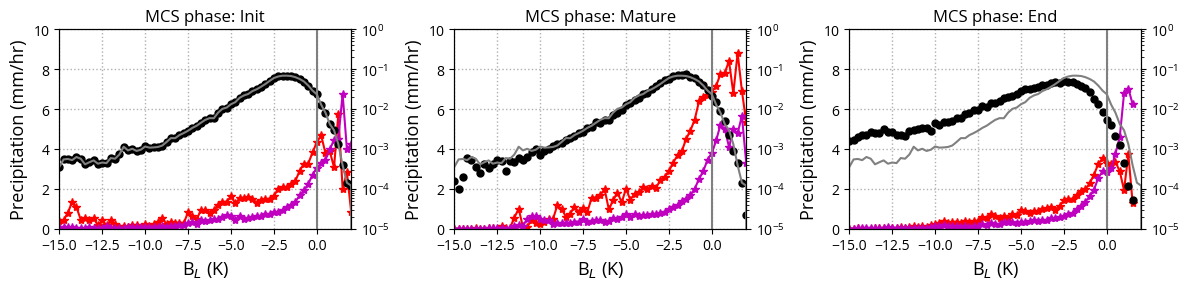

In [190]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(12,3))

for (ax, phase) in zip([ax1,ax2,ax3],['Init','Mature','End']):

    # conditional precip
    tmp = ds_bins.sel(mcs_phase=phase,area_type='mcs').samples
    prec_gpm_cond = ds_bins.sel(mcs_phase=phase,area_type='mcs').precip_sum_gpm/tmp
    prec_era5_cond = ds_bins.sel(mcs_phase=phase,area_type='mcs').precip_sum_era5/tmp    
    ax.plot(tmp.BL_bins, prec_gpm_cond, marker='*', color='r')
    ax.plot(tmp.BL_bins, prec_era5_cond, marker='*', color='m')  
    ax.set_ylim([0,10])
    ax.set_ylabel('Precipitation (mm/hr)',fontsize=13)
    ax.set_xlabel('B$_{L}$ (K)', fontsize=13)
    ax.grid(linestyle=':', linewidth=1)
    ax.set_title('MCS phase: {}'.format(phase))
    
    # pdf
    tmp = ds_bins.sel(mcs_phase=phase,area_type='mcs').samples
    BL_pdf = tmp/np.sum(tmp)
    
    #initial phase pdf overlaid
    tmp2 = ds_bins.sel(mcs_phase='Init',area_type='mcs').samples
    BL_pdf_int = tmp2/np.sum(tmp2)    
    
    axy = ax.twinx()
    axy.plot(tmp.BL_bins, BL_pdf, 'ok', markersize=5)
    if phase == 'End' or 'Mature':
        axy.plot(tmp2.BL_bins, BL_pdf_int, color='grey', markersize=5)
    axy.set_xlim([-15,2])
    axy.set_yticks(np.arange(0,0.175,0.025))
    axy.set_ylim([1e-5, 1])
    axy.vlines(x=0, ymin=1e-5, ymax=1, color='grey')
    axy.set_yscale('log')
    
plt.tight_layout()

#### conditional mean of precip (EAR-5 and GPM)

In [ ]:
%%time

# bins for BL_CAPE and BL_SUBSAT

bins_cape = np.linspace(-2,10,25)
bins_subsat = np.linspace(-2,10,25)
bins_samples = np.zeros((5, len(bins_cape)-1, len(bins_subsat)-1)) # histograms for 5 MCS phases
prec_sum = np.zeros((2, 5, len(bins_cape)-1, len(bins_subsat)-1)) # (source, phase, cape, subsat)

for file in files:
        
    (prec_era5, prec_gpm) = precip_mcs_2dmap(file)
    (BL_TOT, BL_CAPE, BL_SUBSAT, BL_TOT_env, BL_CAPE_env, BL_SUBSAT_env) = BL_mcs_2dmap(file) 
    
    for p, phase in enumerate(["Init", "Grow", "Mature", "Decay", "End"]):

        # ===== for inside mcs =====
        
        prec_era5_phase = prec_era5.sel(mcs_phase = phase).values.ravel()
        prec_gpm_phase = prec_gpm.sel(mcs_phase = phase).values.ravel()
        
        wb = 0.4
        wl = 0.6
        thetae_ref = 340
        
        # ===== for inside mcs ======
        BL_CAPE_phase = BL_CAPE.sel(mcs_phase=phase) # 9.81*(wb*(thetae_bl-thetae_sat_lt)/thetae_sat_lt)
        BL_CAPE_phase = BL_CAPE_phase/9.81/wb*thetae_ref
        BL_SUBSAT_phase = BL_SUBSAT.sel(mcs_phase=phase) # 9.81*(wl*(thetae_sat_lt-thetae_lt)/thetae_sat_lt)
        BL_SUBSAT_phase = BL_SUBSAT_phase/9.81/wl*thetae_ref   

        cape_1d = BL_CAPE_phase.values.ravel() 
        subsat_1d = BL_SUBSAT_phase.values.ravel() 

        for i in range(len(bins_cape)-1):
            idx = np.where(np.logical_and(cape_1d >= bins_cape[i], cape_1d < bins_cape[i+1]))[0]
            for j in range(len(bins_subsat)-1):
                idy = np.where(np.logical_and(subsat_1d >= bins_subsat[j], subsat_1d < bins_subsat[j+1]))[0]

                idx_com = np.intersect1d(idx,idy)
                bins_samples[p,i,j] += len(idx_com)
                
                if len(idx_com) > 0:
                    prec_sum[0,p,i,j] += np.nansum(prec_era5_phase[idx_com])
                    prec_sum[1,p,i,j] += np.nansum(prec_gpm_phase[idx_com])

In [ ]:
# plotting conditional rainrate

fig, ((ax1,ax2,ax3,ax4,ax5), (ax6,ax7,ax8,ax9,ax10)) = plt.subplots(2,5,figsize=(15,6))

for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax1,ax2,ax3,ax4,ax5])):
    
    # conditional mean of gpm
    tmp = prec_sum[1,n,:,:]/bins_samples[n,:,:] 
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=0, vmax=10, cmap=mixedmap)
    
    tmp2 = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
    tmp2[tmp2 == 0] = np.nan
    # contour: fraction of occurrence
    ax.contour(bins_subsat, bins_cape, tmp2,
              levels=[0.005, 0.01, 0.015, 0.02], colors=['k'], linewidths=1)
    
    if n == 4:
        caxes = fig.add_axes([1, 0.62, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('(mm/hr)')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)

    
#### ERA-5 rainfall    
for n, (mcs_phase,ax) in enumerate(zip(['Init','Grow','Mature','Decay','End'],[ax6,ax7,ax8,ax9,ax10])):
    
    # conditional mean of era5 
    tmp = prec_sum[0,n,:,:]/bins_samples[n,:,:]
    tmp[tmp == 0] = np.nan
    
    cp = ax.pcolormesh(bins_subsat, bins_cape, tmp,
                    vmin=0, vmax=5, cmap=mixedmap)
    
    tmp2 = bins_sample[n,:,:]/np.sum(bins_sample[n,:,:])
    tmp2[tmp2 == 0] = np.nan
    # contour: fraction of occurrence
    ax.contour(bins_subsat, bins_cape, tmp2,
              levels=[0.005, 0.01, 0.015, 0.02], colors=['k'], linewidths=1)
    
    if n == 4:
        caxes = fig.add_axes([1, 0.13, 0.01, 0.3])
        cbar = plt.colorbar(cp, cax=caxes)
        cbar.set_label('(mm/hr)')
    ax.set_title(mcs_phase)
    ax.set_xlabel('BL_SUBSAT (K)',fontsize=12)
    ax.set_ylabel('BL_CAPE (K)',fontsize=12)    
    ax.set_ylim([0, 7.5])
    ax.set_xlim([0, 7.5])
    
    # buoyancy reference lines
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13), marker=None, color='k',zorder=2, linewidth=1) # zero buoyancy
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+2, marker=None, color='grey',zorder=2, linewidth=0.5) # +2 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)+1, marker=None, color='grey',zorder=2, linewidth=0.5) # +1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-1, marker=None, color='grey',zorder=2, linewidth=0.5) # -1 K 
    ax.plot(np.linspace(-2,10,13), np.linspace(-2,10,13)-2, marker=None, color='grey',zorder=2, linewidth=0.5) # -2 K 

    ax.grid(linestyle=':', linewidth=0.5)
    
plt.tight_layout()
plt.suptitle('Buoyancy CAPE-SUBSAT conditional precip at MCS phases (all non2mcs tracks)', fontsize=16, fontweight='bold', y=1.05)

In [ ]:
# rebuild the BL-precip relationship based on MCS-associated grids
